# **Food Sales Predictions Project**

---



Import Libraries and Data Into Dataframe

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
filename = '/content/drive/MyDrive/DSDojo/PandasForDataManipulation/sales_predictions.csv'
dfsales = pd.read_csv(filename)

# Data Cleansing

In [28]:
dfsales.head()


Item_Identifier  Item_Weight  ...        Outlet_Type  Item_Outlet_Sales
0           FDA15         9.30  ...  Supermarket Type1          3735.1380
1           DRC01         5.92  ...  Supermarket Type2           443.4228
2           FDN15        17.50  ...  Supermarket Type1          2097.2700
3           FDX07        19.20  ...      Grocery Store           732.3800
4           NCD19         8.93  ...  Supermarket Type1           994.7052

[5 rows x 12 columns]

Remove Duplicates

In [4]:
#remove Duplicates if any:
dfsales.duplicated().any()
# No duplicates in data

False

Check for consistent Data Types

In [30]:
dfsales.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [5]:
#check for odd data types:
dfsales['Item_Outlet_Sales'].sort_values(ascending = False)
#after looking through each item, no mixed data types were found in any of the columns

7188    13086.9648
5223    12117.5600
1450    11445.1020
4349    10993.6896
6541    10306.5840
           ...    
7388       35.2874
3053       34.6216
2571       33.9558
6950       33.2900
906        33.2900
Name: Item_Outlet_Sales, Length: 8523, dtype: float64

Clean Categorical Data

In [6]:
#Check for spelling errors or abbreviations etc in each categorical feature:
dfsales['Outlet_Type'].value_counts()
#Issues only found with one feature

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [7]:
#Issues found with Item Fat Content. Fix below:
dfsales.replace({'Item_Fat_Content':{'LF':'Low Fat','reg':'Regular','low fat':'Low Fat'}}, inplace=True)
# Check with: dfsales['Item_Fat_Content'].value_counts()

In [8]:
# Try to see if missing values can be replaced with logical values if any pattern is identified:
dfsales.info()
#Missing Values found in Item_Weight and Outlet_Size Features
dfsales.groupby(['Outlet_Identifier','Outlet_Size','Outlet_Location_Type'])[['Outlet_Size']].count()
#No pattern Identified for the Outlet_Size nor the Item_Weight features

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


Outlet_Size
Outlet_Identifier Outlet_Size Outlet_Location_Type             
OUT013            High        Tier 3                        932
OUT018            Medium      Tier 3                        928
OUT019            Small       Tier 1                        528
OUT027            Medium      Tier 3                        935
OUT035            Small       Tier 2                        930
OUT046            Small       Tier 1                        930
OUT049            Medium      Tier 1                        930

Deal with Missing Values - Part 1: Flag Missing Values

In [9]:
#Create Flag columns for the missing values:
dfsalesf = dfsales
dfsalesf['No_Item_Weight'] = np.where(dfsalesf['Item_Weight'].isnull(), True, False)
dfsalesf['No_Outlet_Size'] = np.where(dfsalesf['Outlet_Size'].isnull(), True, False)
dfsalesf

Item_Identifier  Item_Weight  ... No_Item_Weight  No_Outlet_Size
0              FDA15        9.300  ...          False           False
1              DRC01        5.920  ...          False           False
2              FDN15       17.500  ...          False           False
3              FDX07       19.200  ...          False            True
4              NCD19        8.930  ...          False           False
...              ...          ...  ...            ...             ...
8518           FDF22        6.865  ...          False           False
8519           FDS36        8.380  ...          False            True
8520           NCJ29       10.600  ...          False           False
8521           FDN46        7.210  ...          False           False
8522           DRG01       14.800  ...          False           False

[8523 rows x 14 columns]

In [36]:
#dfsales['Outlet_Size'].value_counts(dropna = False)

Neaten Column Names

In [ ]:
dfsalesf.rename(columns = {'Item_Identifier':'Item_ID', 'Outlet_Identifier':'Outlet_ID', 'Item_Outlet_Sales':'Sales'}, inplace= True)
dfsalesf

Deal with Missing Values - Part 2: Decide how to handle each use case

**Handeling missing data**

***First Analysis*** 

There are too many missing data too use removal as a resolution. 
Data for the outlet size is MAR. There are certain stores where ALL their data for outloet size is missing
Possible solution for outlet size missing values: 1. Create a 'no size indicated' category/feature value 2. impute the mode (most common value). Though this would
be assuming all the stores are the same size... which is a stretch 3. Look into KNN if thats an option here or hot-deck

Data for Item weight is MAR, all weights for items from stores established in 1985 are missing, none are tier 2 adn none of them are from a large outlet
possible solutions. 1. Since we have data for multiple years succeeding 1985, we could consider dropping the values as we should still be able to predict sales values 
in the future using what we have, however, roughly ~1500 (17%) of the data would then be dropped. 2. We could use MICE ti impute the missing data

***Second Analysis*** 

Outlet Size:

The items missing an outliet size are all from certain stores (eg. ALL stores labeled a,b, and c have NO outlet size, but ALL stores labeled d,e, and f HAVE outlet sizes with 0 missing values)

Therefore, excluding them from the analysis would be detrimental to the model as we would be eliminating multiple entire outlets. Since the owner of the business is new and does not know how nor have access to the outlet sizes for the missing records and I dont feel trying to 'guess' the outlet size based on just outlet type and outlet location type would give us accurate results since there - at least at first glance - does not appear to be any relationship between those features and outlet size. My proposed solution is to replace the missing values with a 'Unknown Size' value. That way the information ~2400 observations will not be lost, but will not influence (too much) the results of our final model.

Item Weight:

I noticed that all the item weights for the year 1985 were missing. After consulting with the owner, we agreed that since the desired result for this analysis is to predict food sales in the future, and since we have 9 other years (where outliets were established) to analyze, AND most importantly, since 1985 is the oldest year in our data set, that we can remove all observations from outlets established in the year 1985 without worrying about its impact on our model. This will remove ~1500 observations from our data BUT, we still have ~7000 observations left to work with that is more than sufficient.

After using the below code to check if we have any items without an item weight that are NOT associated with 1985 outlets, we find that there are none. Therefore after these 2 fixes we are done with dealing with the missing data in this dataset.

```
# dfsalesf[(dfsalesf['Outlet_Establishment_Year']!=1985) & (dfsalesf['Item_Weight'] is None)]
```




In [11]:
#Replace missing outlet size records with 'Unknown Size'
dfSalesFinal = dfsalesf.replace({'Outlet_Size':{None:'Unknown Size'}})
dfSalesFinal

Item_ID  Item_Weight  ... No_Item_Weight  No_Outlet_Size
0      FDA15        9.300  ...          False           False
1      DRC01        5.920  ...          False           False
2      FDN15       17.500  ...          False           False
3      FDX07       19.200  ...          False            True
4      NCD19        8.930  ...          False           False
...      ...          ...  ...            ...             ...
8518   FDF22        6.865  ...          False           False
8519   FDS36        8.380  ...          False            True
8520   NCJ29       10.600  ...          False           False
8521   FDN46        7.210  ...          False           False
8522   DRG01       14.800  ...          False           False

[8523 rows x 14 columns]

In [12]:
# check to see if records were replaced correctly:
dfsales['Outlet_Size'].value_counts(dropna = False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [13]:
dfSalesFinal['Outlet_Size'].value_counts(dropna = False)
# 2410 NaNs = 2410 Unknown Size. therefore replacement worked

Medium          2793
Unknown Size    2410
Small           2388
High             932
Name: Outlet_Size, dtype: int64

In [15]:
#Now lets eliminate the observations from 1985 (which are all missing item weights) We could either eliminate all items were establishment year =1985 or drop all null values from item weights. Im going to choose to
# delete records were year = 1985, since that way if I made an error and there are still missing values outside of 1985 that they wont be eliminated by accident AND this way if the dataset is ever updated I wont be 
#deleting new missing values that may come into the item_weight column
dfSalesFinal = dfSalesFinal[dfSalesFinal['Outlet_Establishment_Year']!=1985]
#Our dataset is now ready to work with

#Some simple sample statistics:

In [18]:

#Items with the highest MRP in each type category:
dfsalesf.groupby(['Item_Type'])['Item_ID','Item_MRP'].max()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  This is separate from the ipykernel package so we can avoid doing imports until


Item_ID  Item_MRP
Item_Type                              
Baking Goods            FDZ60  265.5568
Breads                  FDZ35  263.6594
Breakfast               FDR37  234.9300
Canned                  FDZ49  266.8884
Dairy                   FDZ50  266.6884
Frozen Foods            FDZ52  264.8910
Fruits and Vegetables   FDZ56  264.2252
Hard Drinks             DRQ35  261.4278
Health and Hygiene      NCZ53  266.6884
Household               NCZ54  264.7910
Meat                    FDZ51  261.5936
Others                  NCQ43  254.9040
Seafood                 FDK45  240.2880
Snack Foods             FDZ58  264.9568
Soft Drinks             DRZ24  263.5910
Starchy Foods           FDZ34  263.0252

In [ ]:
#Average Sales per Outlet:
dfsalesf.groupby(['Outlet_ID'])['Sales'].mean().sort_values(ascending = False)

In [ ]:
#Show average Sales per item type over the years
dfsalesf.groupby(['Item_Type','Outlet_Establishment_Year'])[['Sales']].mean()

In [ ]:
# Item category giving the most sales in each year
dfsalesf.groupby(['Outlet_Establishment_Year'])['Sales','Item_Type','Item_ID'].max()

In [ ]:
# Item category giving the least sales in each year
dfsalesf.groupby(['Outlet_Establishment_Year'])['Sales','Item_Type'].min()

In [ ]:
#Number of small, med and large outlets over the years:
dfsalesf.groupby(['Outlet_Establishment_Year','Outlet_Size'])['Outlet_Size'].count()

In [ ]:
#Number of outlet types over the years:
dfsalesf.groupby(['Outlet_Establishment_Year','Outlet_Type'])[['Outlet_Type']].count()

In [ ]:
#Total Cumulative sales over the years:
dfsalesff = dfsalesf
#dfsalesff['Outlet_Establishment_Year']= str(dfsalesff['Outlet_Establishment_Year'])
test = dfsalesff.groupby(['Outlet_Establishment_Year'])[['Sales']].sum()#.sort_values(ascending = False)
test.cumsum()


# Data Visualization

We will now plot some simple graphs to identify any trends, patterns, correclations or oddeties in the data.

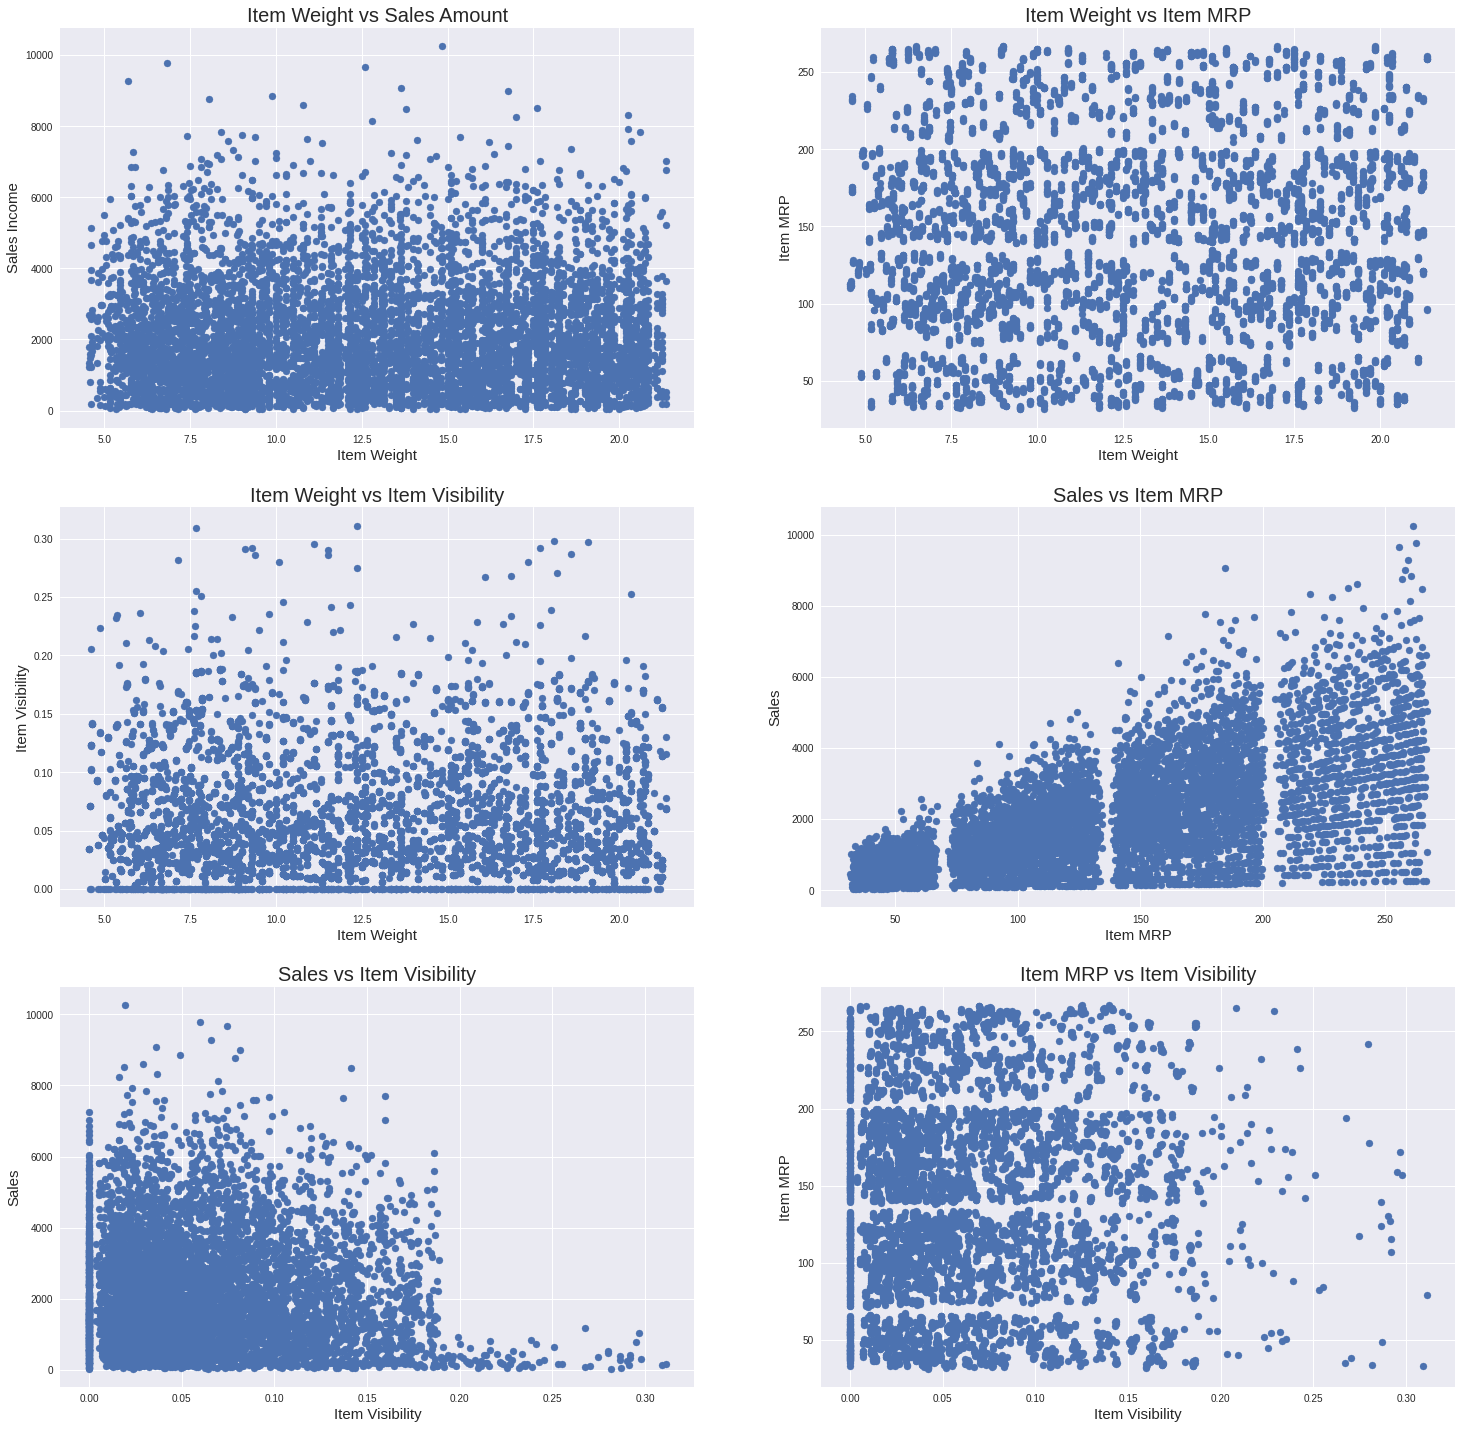

In [17]:
#Lets look at any correlation between qualitative data features:

#Define all variables:

iWeight = dfSalesFinal['Item_Weight']
iSales = dfSalesFinal['Sales']
iVis = dfSalesFinal['Item_Visibility']
iMRP = dfSalesFinal['Item_MRP']

#plot 1: Item weight vs sales

#plot 2: item weightvs Item MRP

#plot 3: item weight vs Item Visibility

#plot 4: Item MRP vs Sales

#plot 5: Item Visibility vs sales

#plot 6 Item MRP vd Item Visibility
plt.figure(figsize = (25,25))
plt.style.use('seaborn')
plt.subplot(3,2,1)
plt.title("Item Weight vs Sales Amount",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Sales Income',fontsize = 15)
plt.scatter(iWeight,iSales)

plt.subplot(3,2,2)
plt.title("Item Weight vs Item MRP",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Item MRP',fontsize = 15)
plt.scatter(iWeight,iMRP)

plt.subplot(3,2,3)
plt.title("Item Weight vs Item Visibility",fontsize = 20)
plt.xlabel('Item Weight',fontsize = 15)
plt.ylabel('Item Visibility',fontsize = 15)
plt.scatter(iWeight,iVis)

plt.subplot(3,2,4)
plt.title("Sales vs Item MRP",fontsize = 20)
plt.xlabel('Item MRP',fontsize = 15)
plt.ylabel('Sales',fontsize = 15)
plt.scatter(iMRP,iSales)

plt.subplot(3,2,5)
plt.title("Sales vs Item Visibility",fontsize = 20)
plt.xlabel('Item Visibility',fontsize = 15)
plt.ylabel('Sales',fontsize = 15)
plt.scatter(iVis,iSales)

plt.subplot(3,2,6)
plt.title("Item MRP vs Item Visibility",fontsize = 20)
plt.xlabel('Item Visibility',fontsize = 15)
plt.ylabel('Item MRP',fontsize = 15)
plt.scatter(iVis,iMRP)

**Findings From Scatter Plots**

Item weight vs sales:
There is no correlation between Item Weight and Sales, though Sales seems to teeter off at some point this is natural as in a supermarket/grocery store you will have way more low cost items then high cost, that has nothing to do with Item Weight

item weight vs Item MRP: Absolutely no correlation

item weight vs Item Visibility: There is no correlation between features. At best there is a low linear correlation. Logically though there is no relationship between an items weight and its visibility, we can see that for all weights we have a wide distribution of items that are both more and less visible


Item MRP vs Sales: There seems to be a low (loose) positive linear correlation between sales and MRP. Though it seems that the higher the sales are the more likely we are to have a stronger (higher) positive linear correlation bewteen the 2 features. This seems logical as the higher priced an item (priced at the MRP limit) the more likely it is to generate more sales revenue if sold, however, just because an item is priced at a higher MRP does not guarentee a sale, which can explain why we have values with varying sales for high MRPs. Conversley, an item with a low MRP can only generate so much revenue, which is why we dont see items with low MRPs in the higher sales brackets.

Item Visibility vs sales: There is a low, loose negative linear correlation between item visibility and sales. This seems to almost be counter intuitive. One would think that the more visible the item is the more likely it is to get sold, however the graph seems to initially indicate otherwise, in that the more visible an item the less likely to gross a higher amount of sales.
Possible reasons could be that when it comes to higher priced items people typically go in knowing what they are looking for, regardless of how much space is given to a displayed item. For example, a person could enter a store with the intention to buy a certain item and go directly to that area, perhaps even asking for the item by name without the need to search for it. Another reason could be that higher priced items may not need to be displayed multiple times, for example, you only need to display one cellphone to sell multiple cellphones, since the dummy model stays on display, unlike having an isle full of bread loaves. Another reason this may occur is that low visibility may give the illusion that an item is in high demand. If I go to the store and a certain brand of chocolate is either sold out or only seems to have a few bars left, it may give the illusion that this item is highly valued by others and may make me want it more and more likely to pay higher prices when I do see it. I'll want to purchase it before it runs out again. Lastly, it may not be cost effective for a store to stock and display high cost, perishable items. People may prefer cheaper alternatives and the high cost items - if displayed in bulk - could persish before being sold, resulting in a loss for the store. It would be better to stock only a few high cost items and sell out, then lose out.It is interesting to note that although there is a lose negative relationship between these variables, that there comes a point were when an item exceeds about 0.18 visibility, that relationship disappears altogther.

Item MRP vd Item Visibility: No correlation of note